In [1]:
import kagglehub
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [2]:
# NYSE dataset for regression
nyse_path = kagglehub.dataset_download("dgawlik/nyse")
print("NYSE dataset path:", nyse_path)

# Machine Predictive Maintenance dataset for classification
maintenance_path = kagglehub.dataset_download("shivamb/machine-predictive-maintenance-classification")
print("Maintenance dataset path:", maintenance_path)

100%|██████████| 30.7M/30.7M [00:00<00:00, 90.9MB/s]

Extracting files...


NYSE dataset path: /root/.cache/kagglehub/datasets/dgawlik/nyse/versions/3


100%|██████████| 137k/137k [00:00<00:00, 42.2MB/s]

Extracting files...
Maintenance dataset path: /root/.cache/kagglehub/datasets/shivamb/machine-predictive-maintenance-classification/versions/1


In [6]:
# Load NYSE data (update path based on Cell 3 output)
data = pd.read_csv(f'{nyse_path}/prices.csv')  # Adjust if filename differs

# Basic exploration
print(data.head())

                  date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  


In [4]:
print(data.describe())

                open          close            low           high  \
count  851264.000000  851264.000000  851264.000000  851264.000000   
mean       70.836986      70.857109      70.118414      71.543476   
std        83.695876      83.689686      82.877294      84.465504   
min         0.850000       0.860000       0.830000       0.880000   
25%        33.840000      33.849998      33.480000      34.189999   
50%        52.770000      52.799999      52.230000      53.310001   
75%        79.879997      79.889999      79.110001      80.610001   
max      1584.439941    1578.130005    1549.939941    1600.930054   

             volume  
count  8.512640e+05  
mean   5.415113e+06  
std    1.249468e+07  
min    0.000000e+00  
25%    1.221500e+06  
50%    2.476250e+06  
75%    5.222500e+06  
max    8.596434e+08  


In [7]:
print(data.isnull().sum())

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64


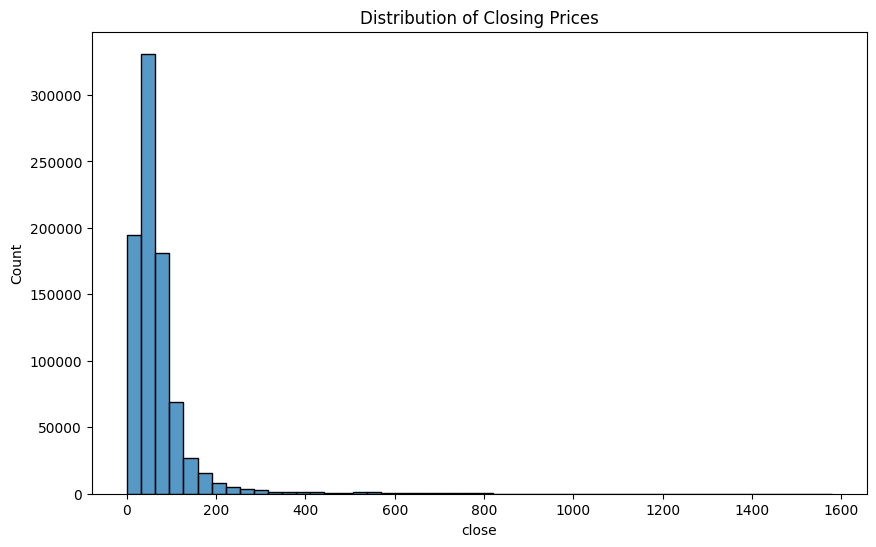

In [8]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.histplot(data['close'], bins=50)
plt.title('Distribution of Closing Prices')
plt.show()

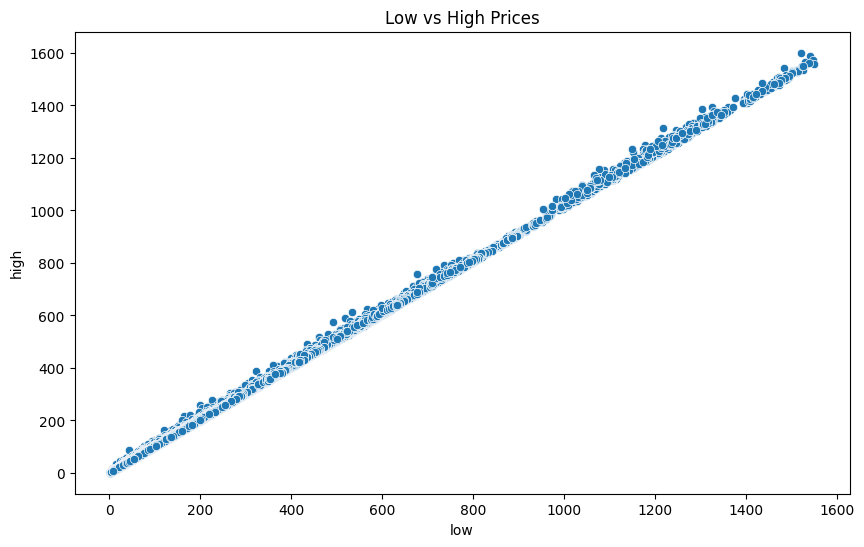

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='low', y='high', data=data)
plt.title('Low vs High Prices')
plt.show()

In [10]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [11]:
# Prepare data
X = data[['open', 'high', 'low']].values
y = data['close'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors and move to GPU
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [12]:
# Define DNN
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:
# Training
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 12036.111328125
Epoch 10, Loss: 10739.236328125
Epoch 20, Loss: 6248.96240234375
Epoch 30, Loss: 493.83868408203125
Epoch 40, Loss: 848.0899658203125
Epoch 50, Loss: 226.25411987304688
Epoch 60, Loss: 78.39341735839844
Epoch 70, Loss: 63.45081329345703
Epoch 80, Loss: 26.783191680908203
Epoch 90, Loss: 14.294029235839844


In [14]:
class PyTorchRegressor:
    def __init__(self, lr=0.01, optimizer='adam'):
        self.model = DNN().to(device)
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr) if optimizer == 'adam' else torch.optim.SGD(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def fit(self, X, y, epochs=50):
        # Check if X and y are already tensors; if not, convert them and move to GPU
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X).to(device)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y).to(device)
        # Ensure X and y are on the correct device
        X = X.to(device)
        y = y.to(device)
        for _ in range(epochs):
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y.view(-1, 1))
            loss.backward()
            self.optimizer.step()

    def predict(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X).to(device)
        X = X.to(device)
        self.model.eval()
        with torch.no_grad():
            return self.model(X).cpu().numpy()

In [15]:
# Manual GridSearch
param_grid = {'lr': [0.001, 0.01, 0.1], 'optimizer': ['adam', 'sgd']}
best_loss = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    model = PyTorchRegressor(lr=params['lr'], optimizer=params['optimizer'])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    loss = nn.MSELoss()(torch.FloatTensor(pred), y_test.cpu().view(-1, 1)).item()
    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss}')

Best params: {'lr': 0.1, 'optimizer': 'adam'}, Best loss: 21.16643714904785


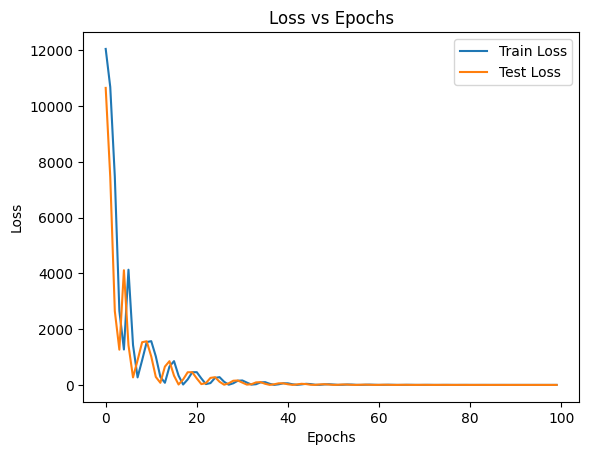

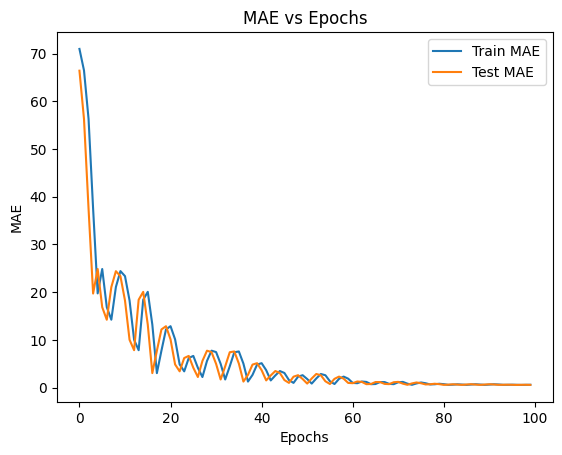

Interpretation: If train loss decreases but test loss flattens, it suggests overfitting.


In [16]:
model = DNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
train_losses, test_losses, train_maes, test_maes = [], [], [], []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    train_mae = torch.mean(torch.abs(outputs - y_train.view(-1, 1))).item()
    train_maes.append(train_mae)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test.view(-1, 1))
        test_losses.append(test_loss.item())
        test_mae = torch.mean(torch.abs(test_outputs - y_test.view(-1, 1))).item()
        test_maes.append(test_mae)

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_maes, label='Train MAE')
plt.plot(test_maes, label='Test MAE')
plt.title('MAE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

print("Interpretation: If train loss decreases but test loss flattens, it suggests overfitting.")

In [18]:
class DNNRegularized(nn.Module):
    def __init__(self):
        super(DNNRegularized, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
model = DNNRegularized().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=0.01)
train_losses_reg, test_losses_reg, train_maes_reg, test_maes_reg = [], [], [], []

In [19]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()
    train_losses_reg.append(loss.item())
    train_mae = torch.mean(torch.abs(outputs - y_train.view(-1, 1))).item()
    train_maes_reg.append(train_mae)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test.view(-1, 1))
        test_losses_reg.append(test_loss.item())
        test_mae = torch.mean(torch.abs(test_outputs - y_test.view(-1, 1))).item()
        test_maes_reg.append(test_mae)

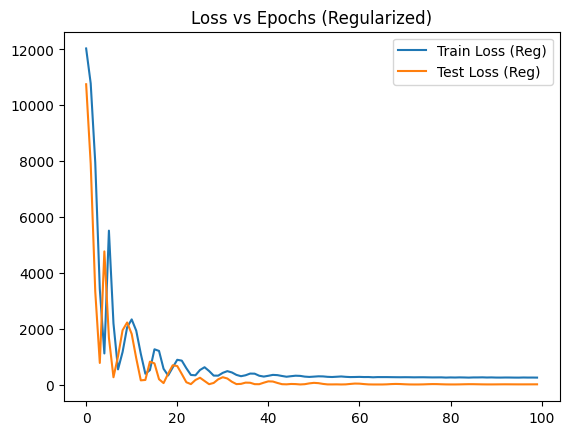

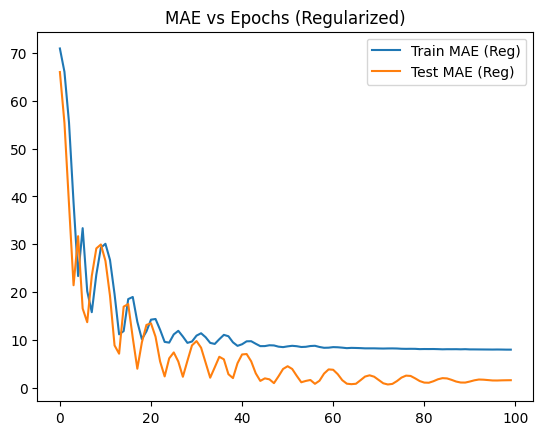

Comparison: Regularized model should have lower test loss/MAE if overfitting was reduced.


In [20]:
# Plot
plt.plot(train_losses_reg, label='Train Loss (Reg)')
plt.plot(test_losses_reg, label='Test Loss (Reg)')
plt.title('Loss vs Epochs (Regularized)')
plt.legend()
plt.show()

plt.plot(train_maes_reg, label='Train MAE (Reg)')
plt.plot(test_maes_reg, label='Test MAE (Reg)')
plt.title('MAE vs Epochs (Regularized)')
plt.legend()
plt.show()

print("Comparison: Regularized model should have lower test loss/MAE if overfitting was reduced.")

In [21]:

# Load data (update path based on Cell 3 output)
data = pd.read_csv(f'{maintenance_path}/predictive_maintenance.csv')  # Adjust if filename differs

# Clean and preprocess
print(data.isnull().sum())  # Check for missing values
data = data.drop(['UDI', 'Product ID', 'Failure Type'], axis=1)  # Drop irrelevant columns
data = pd.get_dummies(data, columns=['Type'], drop_first=True)  # Encode 'Type'
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
data[numerical_cols] = StandardScaler().fit_transform(data[numerical_cols])  # Standardize numerical features

X = data.drop('Target', axis=1).values
y = data['Target'].values


UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


       Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         1.000000e+04             1.000000e+04            1.000000e+04   
mean         -9.322321e-16            -1.693934e-15           -2.330580e-16   
std           1.000050e+00             1.000050e+00            1.000050e+00   
min          -2.352278e+00            -2.901986e+00           -2.068196e+00   
25%          -8.523974e-01            -8.125581e-01           -6.458012e-01   
50%           4.753123e-02             6.365340e-02           -1.995597e-01   
75%           7.474757e-01             7.376623e-01            4.084443e-01   
max           2.247357e+00             2.557486e+00            7.514840e+00   

        Torque [Nm]  Tool wear [min]        Target  
count  1.000000e+04     1.000000e+04  10000.000000  
mean   5.424994e-16     1.051603e-16      0.033900  
std    1.000050e+00     1.000050e+00      0.180981  
min   -3.630149e+00    -1.695984e+00      0.000000  
25%   -6.808401e-01    

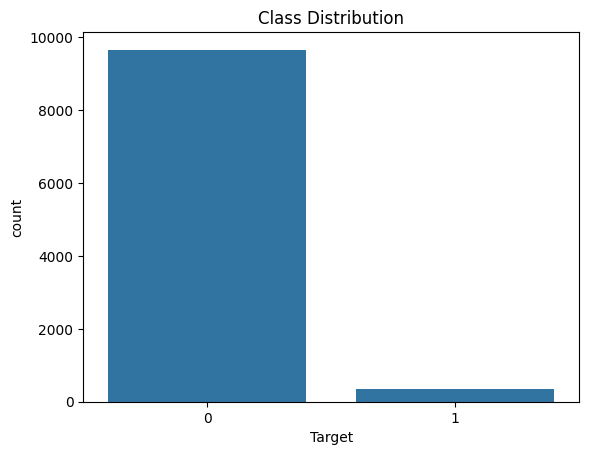

In [23]:
print(data.describe())  # Summary statistics
sns.countplot(x='Target', data=data)  # Class distribution
plt.title('Class Distribution')
plt.show()

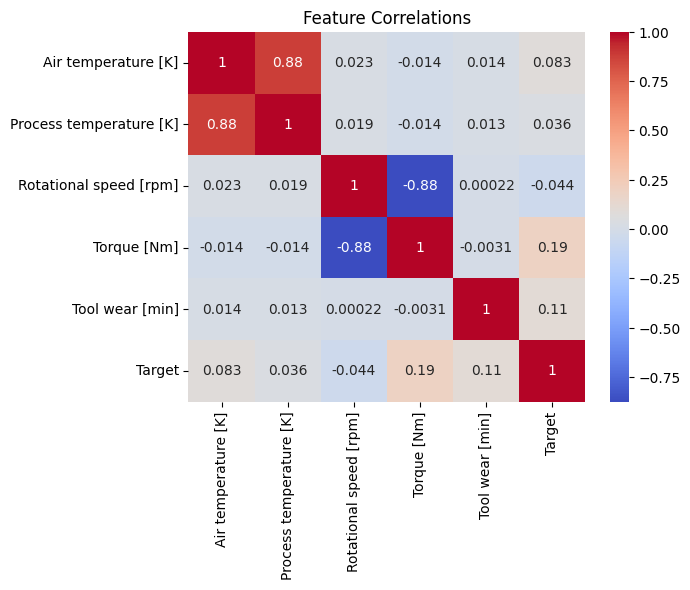

In [24]:
# Correlation heatmap on numeric columns only
numeric_data = data.select_dtypes(include=['float64', 'int64', 'uint8'])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

In [25]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)  # Balance the dataset
print(pd.Series(y_balanced).value_counts())  # Verify class balance

0    9661
1    9661
Name: count, dtype: int64


In [27]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)
# Define DNN
class DNNClassifier(nn.Module):
    def __init__(self):
        super(DNNClassifier, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)  # Input size matches features
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # 2 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


Using device: cuda


In [28]:
# Test training
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.6850440502166748
Epoch 1, Loss: 0.6327990889549255
Epoch 2, Loss: 0.583762526512146
Epoch 3, Loss: 0.5365870594978333
Epoch 4, Loss: 0.49040260910987854
Epoch 5, Loss: 0.44456201791763306
Epoch 6, Loss: 0.4031026065349579
Epoch 7, Loss: 0.37266817688941956
Epoch 8, Loss: 0.352809876203537
Epoch 9, Loss: 0.3378725051879883


In [29]:
class PyTorchClassifier:
    def __init__(self, lr=0.01, optimizer='adam'):
        self.model = DNNClassifier().to(device)
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr) if optimizer == 'adam' else torch.optim.SGD(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()

    def fit(self, X, y, epochs=50):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X).to(device)
        if not isinstance(y, torch.Tensor):
            y = torch.LongTensor(y).to(device)
        X = X.to(device)
        y = y.to(device)
        for _ in range(epochs):
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()

    def predict(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X).to(device)
        X = X.to(device)
        self.model.eval()
        with torch.no_grad():
            return self.model(X).argmax(dim=1).cpu().numpy()

# Manual GridSearch
param_grid = {'lr': [0.001, 0.01, 0.1], 'optimizer': ['adam', 'sgd']}
best_acc = 0
best_params = None

for params in ParameterGrid(param_grid):
    model = PyTorchClassifier(lr=params['lr'], optimizer=params['optimizer'])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test.cpu(), pred)
    if acc > best_acc:
        best_acc = acc
        best_params = params

print(f'Best params: {best_params}, Best accuracy: {best_acc}')

Best params: {'lr': 0.01, 'optimizer': 'adam'}, Best accuracy: 0.943078913324709


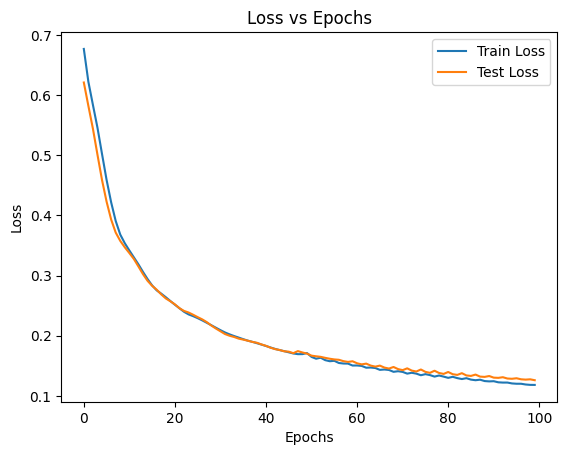

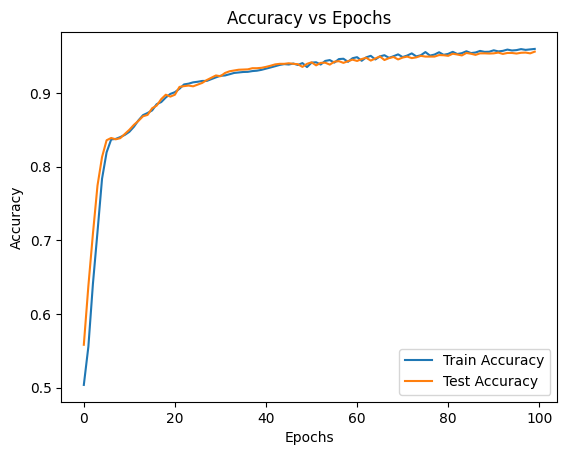

Interpretation: Stable test accuracy with decreasing loss indicates good generalization.


In [30]:
model = DNNClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
train_losses, test_losses, train_accs, test_accs = [], [], [], []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    train_acc = accuracy_score(y_train.cpu(), outputs.argmax(dim=1).cpu().detach().numpy())
    train_accs.append(train_acc)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
        test_acc = accuracy_score(y_test.cpu(), test_outputs.argmax(dim=1).cpu().numpy())
        test_accs.append(test_acc)

# Plots
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("Interpretation: Stable test accuracy with decreasing loss indicates good generalization.")

In [31]:
model.eval()
with torch.no_grad():
    pred = model(X_test).argmax(dim=1).cpu().numpy()
print(f'Accuracy: {accuracy_score(y_test.cpu(), pred)}')
print(f'Sensitivity: {recall_score(y_test.cpu(), pred)}')
print(f'F1 Score: {f1_score(y_test.cpu(), pred)}')

Accuracy: 0.9560155239327296
Sensitivity: 0.969963749352667
F1 Score: 0.95658835546476


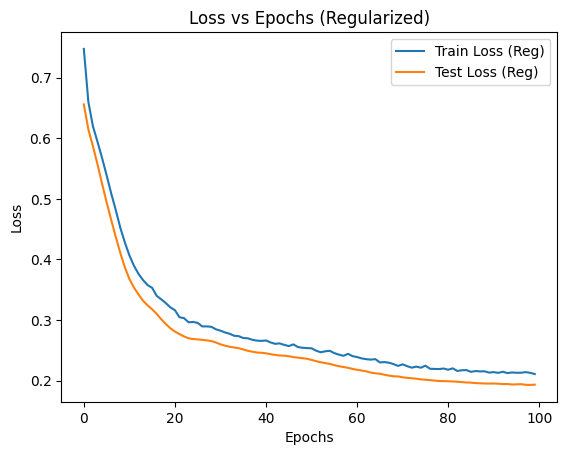

In [34]:
class DNNClassifierRegularized(nn.Module):
    def __init__(self):
        super(DNNClassifierRegularized, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = DNNClassifierRegularized().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=0.01)
train_losses_reg, test_losses_reg, train_accs_reg, test_accs_reg = [], [], [], []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses_reg.append(loss.item())
    train_acc = accuracy_score(y_train.cpu(), outputs.argmax(dim=1).cpu().detach().numpy())
    train_accs_reg.append(train_acc)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses_reg.append(test_loss.item())
        test_acc = accuracy_score(y_test.cpu(), test_outputs.argmax(dim=1).cpu().numpy())
        test_accs_reg.append(test_acc)
# Plots
plt.plot(train_losses_reg, label='Train Loss (Reg)')
plt.plot(test_losses_reg, label='Test Loss (Reg)')
plt.title('Loss vs Epochs (Regularized)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

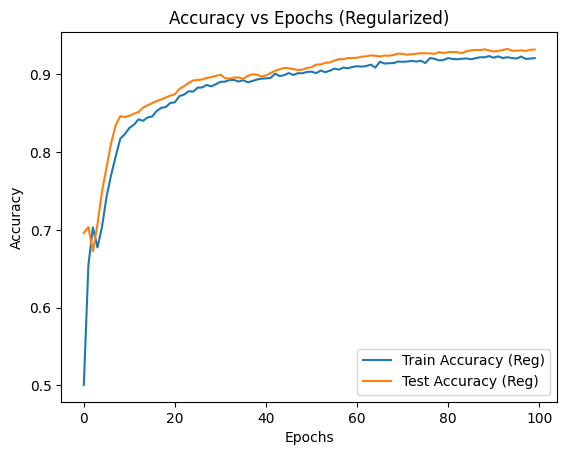

Comparison: Regularized model may show better test accuracy if overfitting was reduced.


In [35]:
plt.plot(train_accs_reg, label='Train Accuracy (Reg)')
plt.plot(test_accs_reg, label='Test Accuracy (Reg)')
plt.title('Accuracy vs Epochs (Regularized)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("Comparison: Regularized model may show better test accuracy if overfitting was reduced.")